In [18]:
# GENERAL IMPORTS
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob
import os
from pprint import pprint
# from collections import deque

# FILE IMPORTS
from config_file import Config

conf = Config()
ROOT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))

In [32]:
folders = glob.glob(os.path.join(ROOT_DIR, "data", "stereodataset", "*"))
N_IMAGES = len(folders)

dataset = []

for folder in folders:
    with open(os.path.join(folder, "param_in.txt")) as f:
        params = f.readlines()
        data = {
            "ref": params[0].split(" ")[1].strip(),
            "gt": params[1].split(" ")[1].strip(),
            "disp_min": params[3].split(" ")[1].strip(),
            "disp_max": params[4].split(" ")[1].strip(),
            "disp_scale": params[5].split(" ")[1].strip(),
            "ignore_border": params[7].split(" ")[1].strip()
        }
        dataset.append(data)


def read_image(path):
    # if path.split(".")[-1] == "pgm":
        img = cv2.imread(path, -1)
        print(img.shape)
        plt.imshow(img, cmap="gray", vmin=0, vmax=255)
        plt.show()
        return img


0
(216, 284)


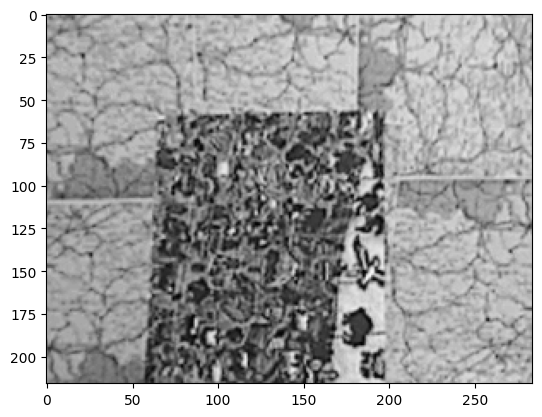

1
(383, 434, 3)


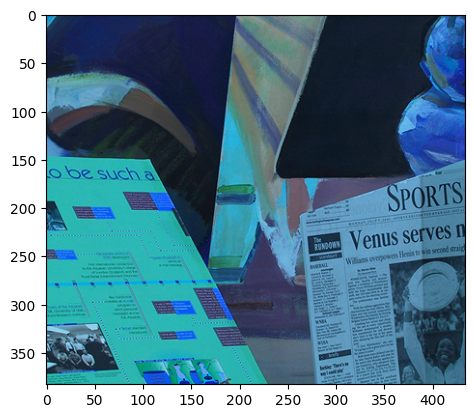

2
(380, 434, 3)


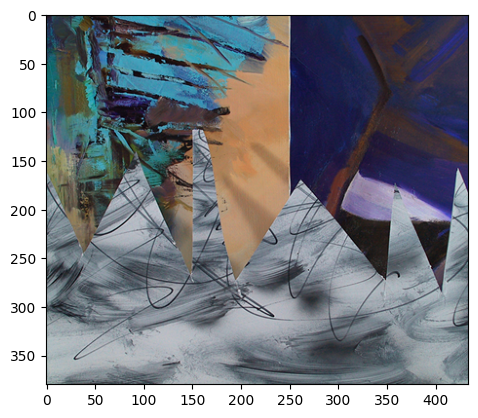

3
(288, 384, 3)


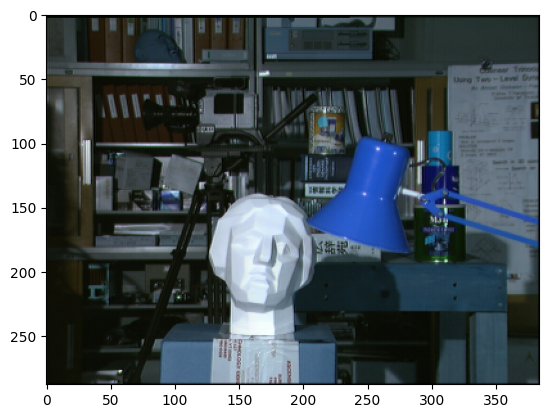

In [33]:
for i, data in enumerate(dataset):
    print(i)
    read_image(os.path.join(folders[i], data["ref"]))


In [ ]:
def check_img_channels(img1, img2) -> bool:
    '''
    Returns True if both are RGB, False is grayscale, raises an error otherwise
    '''
    if len(img1.shape) != len(img2.shape):
        raise ValueError("The two images mush have the same numbero of channels: img1 shape = {} and img2 shape = {}".format(img1.shape, img2.shape))
    elif len(img1.shape) == 3:
        if img1.shape[-1] == 3:
            rgb_flag = True
        elif img1.shape[-1] == 1:
            rgb_flag = False
        else:
            raise ValueError("The images can either have 3 channels (RGB) or 1 (grayscale): # of channels of img1 = {}".format(img1.shape[-1]))
        
    return rgb_flag


def SAD(img1, img2, k, disparity_range, search_area=False) -> float:
    '''
    Returns a matrix [h-2k, w-2k, d] with SAD value for each pixel and disparity in disparity range
    You will need to compute at least a np.min on the last axis to use it
    '''
    # compute the Sum of Absolute Distances between intensities of the two images
    # in disparity map computation you only need to compare the left pixel (and patch around it) with an horizontal segment in the right image (the disparity_range)
    if search_area != False:
        i_min, i_max, j_min, j_max = search_area
    else:
        h, w = img1.shape[:2]
        i_min = k
        i_max = h-k
        j_min = k
        j_max = w-k

    disparity_map = np.zeros((i_max-i_min, j_max-j_min, len(disparity_range)))

    rgb_flag = check_img_channels(img1, img2) # do we need this?

    # compute SAD for each pixel patch wrt its "disparity counterpart" for each d value
    for d in disparity_range:
        if rgb_flag:
            # distance in RGB is eucledian, so square channels and take sqrt of sum
            disparity_pixelwise = np.square(img1[i_min-k:i_max+k+1, j_min-k:j_max+k+1, :] - img2[i_min-k:i_max+k+1, j_min-k+(d):j_max+k+1+(d), :])
            disparity_pixelwise = np.sqrt(np.sum(disparity_pixelwise, axis=-1))

            # now create values for each pixel = sum of values in neighbouring pixels 
            for i in range(i_min, i_max+1):
                for j in range(j_min, j_max+1):
                    disparity_map[i, j, d] = np.sum(disparity_pixelwise[i-k:i+k+1, j-k+(d):j+k+1+(d),:])
        
        else:
            # in grayscale you only need ABS
            disparity_pixelwise = np.abs(img1[i_min-k:i_max+k+1, j_min-k:j_max+k+1, :] - img2[i_min-k:i_max+k+1, j_min-k+(d):j_max+k+1+(d)])
            for i in range(i_min, i_max+1):
                for j in range(j_min, j_max+1):
                    disparity_map[i, j, d] = np.sum(disparity_pixelwise[i-k:i+k+1, j-k+(d):j+k+1+(d)])
    
    return disparity_map

# need to compute the min along disparity axis to find disparity for each pixel
disparity_map = np.min(SAD(img1, img2, 19, conf.d_range), axis=-1)

plt.imshow(disparity_map, cmap="grayscale", vmin=0, vmax=255)

In [ ]:
def evaluation_dense(gt, prediction, ignore_border=0):
    '''
    eval = mean "correctness", where correctness of a disparity measure is 0 if the error is <= 1, 1 otherwise
    '''
    h, w = gt.shape[:2]
    b = ignore_border
    difference = np.abs(gt[b:h-b+1, b:w-b+1] - prediction[b:h-b+1, b:w-b+1]) - 1 # min_value is -1
    difference = np.minimum(difference, 1) # cap the image to max_value = 1
    difference = np.maximum(difference, 0) # cap the image to min_value = 0
    return np.mean(difference)

In [ ]:
def moravec(img):
    '''
    Returns "cornerness" of each pixel through the moravec operator
    The returned matrix is reduced on all sides by 1 pixel, because moravec operator
    '''
    directional_differences = []
    for m in range(-1, 2):
        for n in range(-1, 2):
            if m == 0 and n == 0:
                pass
            else:
                if len(img.shape) == 3:
                    # check (1+m:-1+m --> not always negative)
                    difference = np.square(img[1:-1, 1:-1, :] - img[1+m:-1+m, 1+n:-1+n, :])
                    difference = np.sum(difference, axis=-1)
                else:
                    difference = np.square(img[1:-1, 1:-1] - img[1+m:-1+m, 1+n:-1+n])

                directional_differences.append(difference)

    directional_differences = np.stack(directional_differences)
    min_difference = np.min(directional_differences, axis=-1)

    return min_difference


def get_moravec_mask(img, threshold):
    img_interestingness = moravec(img)
    return img_interestingness > threshold


def get_top_right_corner_displacement(interest_mask, disparity):
    h, w = interest_mask.shape[:2]
    h_m, w_m = disparity.shape
    return (h-h_m)/2, (w-w_m)/2


In [ ]:
def get_disparity_mask(disparity_map, th_ratio, th_peak):
    '''
    Returns a boolean mask with 0 if a pixel doesn't have a "good" maximum in its disparity values,
    1 otherwise
    '''
    h, w = disparity_map.shape[:2]
    disparity_mask = np.ones((h, w))
    disparity_map_derivative = disparity_map[:,:,:-1] - disparity_map[:,:,1:]
    
    for i in range(h):
        for j in range(w):
            disparities = list(disparity_map[i, j, :])
            peak_1_idx = np.argmax(disparities)
            peak_1_value = disparities.pop(peak_1_idx)
            peak_2_value = np.max(disparities)

            if peak_2_value > peak_1_value*th_ratio:
                disparity_mask[i, j] = 0
            
            if disparity_map_derivative[i, j, peak_1_idx] + \
                    disparity_map_derivative[i, j, peak_1_idx+1] < 2*th_peak:
                disparity_mask[i, j] = 0

    return disparity_mask



def evaluation_sparse(gt_disparity, prediction_disparity, interest_mask=False, disparity_mask=False, ignore_border=0):
    '''
    Returns mean correctness of disparity prediction taking into account ONLY:
        - interest_mask: the pixels of the image on which we want to compute disparity
        - disparity_mask: the pixels of the image in which the disparity maximum was accepted
    
    '''
    
    if disparity_mask == False:
        disparity_mask = np.ones_like(prediction_disparity)
    if interest_mask == False:
        interest_mask = np.ones_like(prediction_disparity)

    i, j = get_top_right_corner_displacement(interest_mask, prediction_disparity)
    interest_mask = interest_mask[i:-i, j:-j]
    final_mask = np.multiply(interest_mask, disparity_mask)
    N_area = np.sum(final_mask)

    h, w = gt_disparity.shape[:2]
    b = ignore_border
    difference = np.abs(gt_disparity[b:h-b+1, b:w-b+1] - prediction_disparity[b:h-b+1, b:w-b+1]) # min_value is 0
    difference = np.minimum(difference, 1) # cap the image to max_value = 1
    difference = np.multiply(difference, final_mask)

    return np.sum(difference) / N_area, N_area / (gt_disparity.shape[0] * gt_disparity.shape[1])